In [1]:
%matplotlib inline

import gdal
import rasterio
import matplotlib.pyplot as plt
import numpy as np

In [2]:
cd BayAreaLandsat/

C:\Users\zstat\Documents\Python\GeoExperiments\BayAreaLandsat


In [3]:
ls

 Volume in drive C is OS
 Volume Serial Number is B22A-961A

 Directory of C:\Users\zstat\Documents\Python\GeoExperiments\BayAreaLandsat

06/02/2018  04:29 PM    <DIR>          .
06/02/2018  04:29 PM    <DIR>          ..
05/31/2018  10:23 PM        56,725,957 LC08_L1TP_044034_20180329_20180405_01_T1_B2.TIF
06/02/2018  02:00 PM               119 LC08_L1TP_044034_20180329_20180405_01_T1_B2.TIF.aux.xml
06/02/2018  02:00 PM        20,139,752 LC08_L1TP_044034_20180329_20180405_01_T1_B2.TIF.ovr
05/31/2018  10:23 PM        58,118,196 LC08_L1TP_044034_20180329_20180405_01_T1_B3.TIF
05/31/2018  10:23 PM        59,154,346 LC08_L1TP_044034_20180329_20180405_01_T1_B4.TIF
05/31/2018  10:23 PM        63,038,558 LC08_L1TP_044034_20180329_20180405_01_T1_B5.TIF
06/01/2018  09:32 PM           506,421 LC08_L1TP_044034_20180329_20180405_01_T1_BQA.TIF
               7 File(s)    257,683,349 bytes
               2 Dir(s)  315,978,842,112 bytes free


In [4]:
RED_fn = 'LC08_L1TP_044034_20180329_20180405_01_T1_B4.TIF'
NIR_fn = 'LC08_L1TP_044034_20180329_20180405_01_T1_B5.TIF'

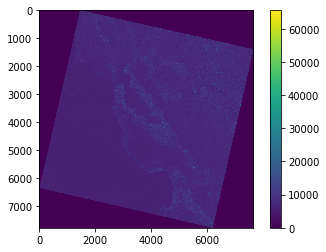

In [5]:
red_ds = gdal.Open(RED_fn)
red_band = red_ds.GetRasterBand(1)
red = red_band.ReadAsArray()
plt.imshow(red)
plt.colorbar()

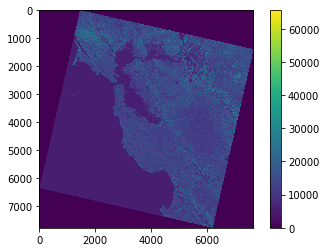

In [6]:
nir_ds = gdal.Open(NIR_fn)
nir_band = nir_ds.GetRasterBand(1)
nir = nir_band.ReadAsArray()
plt.imshow(nir)
plt.colorbar()

In [7]:
def ndvi(red, nir):
    """Calculate NDVI."""
    return (nir - red) / (nir + red)

In [8]:
print gdal.GetDataTypeName(red_band.DataType), red.dtype
print gdal.GetDataTypeName(nir_band.DataType), nir.dtype

UInt16 uint16
UInt16 uint16


C:\Users\zstat\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until


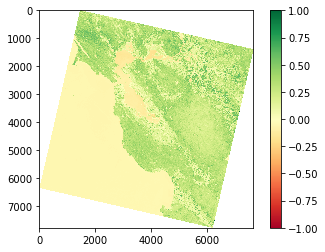

In [9]:
#convert invert arrays to floating point
red = red.astype(np.float64)
nir = nir.astype(np.float64)

ndvi = ndvi(red, nir)
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar()

In [10]:
# confirm this band doesn't have a no data value
print red_band.GetNoDataValue()

None


C:\Users\zstat\Anaconda2\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in divide
  # Remove the CWD from sys.path while we load stuff.


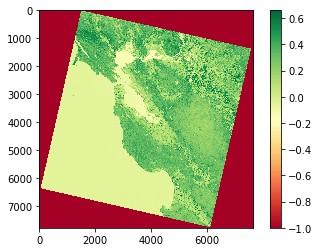

In [11]:
#Using the band with extra metadata (_BQA.tif) I will set any pixel marked as filler(1) to - 1 
#and any pixel with denominator of 0 to -1
QA_fn = 'LC08_L1TP_044034_20180329_20180405_01_T1_BQA.TIF'

qa_ds = gdal.Open(QA_fn)
qa_band = qa_ds.GetRasterBand(1)
qa = qa_band.ReadAsArray()

def ndvi_with_nodata(red, nir, qa):
    ndvi = (nir - red) / (nir + red)
    ndvi[qa == 1] = -1
    ndvi[(nir + red) == 0] = -1
    return ndvi

ndvi = ndvi_with_nodata(red, nir, qa)
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar()

In [12]:
ndvi.dtype

dtype('float64')

In [13]:
#playing around with coordinate systems
with rasterio.open(RED_fn) as red_raster:
    source_crs = red_raster.crs
    source_transform = red_raster.transform
    print source_crs
    print source_transform

C:\Users\zstat\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2878: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)


CRS({'init': u'epsg:32610'})
[462885.0, 30.0, 0.0, 4264215.0, 0.0, -30.0]


In [17]:
from osgeo import gdal

with rasterio.open(RED_fn) as red_raster:
    source_crs = red_raster.crs
    source_transform = red_raster.transform
    
with rasterio.open('ndvi.tif', 'w', driver='GTIff',
                   height=ndvi.shape[0],    # numpy of rows
                   width=ndvi.shape[1],     # number of columns
                   count=1,                        # number of bands
                   dtype=rasterio.dtypes.float64,  # this must match the dtype of our array
                   crs=source_crs,
                   transform=source_transform) as ndvi_raster:
    ndvi_raster.write(ndvi, 1)  # optional second parameter is the band number to write to
    ndvi_raster.nodata = -1  # set the raster's nodata value